In [325]:
# import libraries
import pandas as pd
import seaborn as sns
import sqlite3 as db
import matplotlib.pyplot as plt

In [326]:
# creating connection
connection = db.connect("olist.db")

# create cursor
curs = connection.cursor()

# execute query
df = curs.execute("SELECT name FROM sqlite_master WHERE type = 'table'")

# show all tables
df.fetchall()

[('olist_order_customer_dataset',),
 ('olist_order_dataset',),
 ('olist_order_reviews_dataset',),
 ('olist_order_payments_dataset',),
 ('olist_order_items_dataset',),
 ('olist_products_dataset',),
 ('olist_sellers_dataset',),
 ('olist_geolocation_dataset',),
 ('product_category_name_translation',)]

# 1 Data Import
My objectives in this analysis are:
1. to discover the top-selling products in the e-commerce company's platform;
2. to find out the customers' most preferred payment methods when buying products from company; and
3. to examine which products are top and least rated based on their reviews.

For these objectives, I will need datasets on the products sold (`olist_products_dataset` and `product_category_name_translation`), the payment methods (`olist_order_payments_dataset`), and product reviews (`olist_order_reviews_dataset`). However, because some datasets do not relate each other directly, I will need `order_item_tbl` which contains columns `order_id` and `product_id` when merging them.

## 1.1 Importing datasets

In [327]:
# product dataset
product_tbl = pd.read_sql_query(
    """
    SELECT product_id, product_category_name
    FROM olist_products_dataset;
    """, connection)

# payment dataset
payment_tbl = pd.read_sql_query(
    """
    SELECT order_id, payment_type, payment_value 
    FROM olist_order_payments_dataset;
    """, connection)

# review dataset
review_tbl = pd.read_sql_query(
    """
    SELECT order_id, review_score 
    FROM olist_order_reviews_dataset;
    """, connection)
    
# order items dataset
order_item_tbl = pd.read_sql_query(
    """
    SELECT order_id, product_id
    FROM olist_order_items_dataset;
    """, connection)
    
# category name translation dataset
category_trans_tbl = pd.read_sql_query(
    """
    SELECT product_category_name, product_category_name_english
    FROM product_category_name_translation;
    """, connection)

In [328]:
# order_dataset
order_tbl = pd.read_sql_query(
    """
    SELECT order_id, order_purchase_timestamp
    FROM olist_order_dataset;
    """, connection)

**Note**: During the data import, I directly perform selections of relevant columns so data wrangling will be more time-efficient.

## 1.2 Checking datasets

In [329]:
# check product_tbl
product_tbl.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [330]:
# check product_category_name_translation
category_trans_tbl.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [331]:
# check review_tbl
review_tbl.head()

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [332]:
# check order_item_tbl
order_item_tbl.head()

,order_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089


# 2 Data Merging
The procedure here is:
1. to merge `payment_tbl` with `review_tbl` by `order_id`, and store the result in `join_tbl`;
2. to merge `join_tbl` with `order_item_tbl` by `order_id`, and save the result in `join_tbl`;
3. to merge `join_tbl` with `order_tbl` by `order_id`, and continue to store the result in the same name of joined dataset;
4. to merge `join_tbl` with `product_tbl` by `product_id`, and save the result in `join_tbl`;
5. to merge `join_tbl` with `category_trans_tbl`.

In [333]:
# combine payment_tbl and review_tbl, stored in join_tbl
join_tbl = payment_tbl.merge(review_tbl, on="order_id")

# combine join_tbl and order_item_tbl, stored in join_tbl
join_tbl = join_tbl.merge(order_item_tbl, on="order_id")

# combine join_tbl and order_tbl, stored in join_tbl
join_tbl = join_tbl.merge(order_tbl, on="order_id")

# combine join_tbl and product_tb, stored in join_tbl
join_tbl = join_tbl.merge(product_tbl, on="product_id")

# combine join_tbl and categor_trans_tbl, stored in join_tbl
join_tbl = join_tbl.merge(category_trans_tbl, on="product_category_name")

# check the dimension (ncol & nrow)
join_tbl.shape

(115609, 8)

## 2.1 Data description

In [334]:
# top five-rows of the join dataset
join_tbl.head()

,order_id,payment_type,payment_value,review_score,product_id,order_purchase_timestamp,product_category_name,product_category_name_english
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33,1,af74cc53dcffc8384b29e7abfa41902b,2018-04-25 22:01:49,casa_construcao,home_construction
1,d86305c284cecff56c7ee9d3fbd4f8d6,credit_card,93.72,4,af74cc53dcffc8384b29e7abfa41902b,2018-04-15 22:53:59,casa_construcao,home_construction
2,b545ba7b0bd67a3128185c7214704319,credit_card,340.08,4,2233b59e8cf2817f9659e52cce3093de,2018-06-11 14:59:24,casa_construcao,home_construction
3,6a26bd1a037993f1205073dbeda67db4,credit_card,67.12,4,679a3e5e1d2bb68982be5734c6e55e63,2018-02-15 13:53:42,casa_construcao,home_construction
4,1d84d00f6d2334d63f35ba528cd0d99d,boleto,63.74,5,679a3e5e1d2bb68982be5734c6e55e63,2018-02-10 16:50:42,casa_construcao,home_construction


In [335]:
# drop product_category_name
join_tbl.drop(columns=["product_category_name"], inplace=True, axis=1)

# recheck the result
join_tbl.head()

,order_id,payment_type,payment_value,review_score,product_id,order_purchase_timestamp,product_category_name_english
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33,1,af74cc53dcffc8384b29e7abfa41902b,2018-04-25 22:01:49,home_construction
1,d86305c284cecff56c7ee9d3fbd4f8d6,credit_card,93.72,4,af74cc53dcffc8384b29e7abfa41902b,2018-04-15 22:53:59,home_construction
2,b545ba7b0bd67a3128185c7214704319,credit_card,340.08,4,2233b59e8cf2817f9659e52cce3093de,2018-06-11 14:59:24,home_construction
3,6a26bd1a037993f1205073dbeda67db4,credit_card,67.12,4,679a3e5e1d2bb68982be5734c6e55e63,2018-02-15 13:53:42,home_construction
4,1d84d00f6d2334d63f35ba528cd0d99d,boleto,63.74,5,679a3e5e1d2bb68982be5734c6e55e63,2018-02-10 16:50:42,home_construction


After removing the `product_category_name`, the `join_tbl` contains 7 columns and 115609 rows. In addition to the data index on the left, the columns consists of
1. `order_id`: unique order identifier consisting of a combination between numbers and lower-cased letters
2. `payment_type`: preferred payment methods such as credit or debit cards
3. `payment_value`: transaction value
4. `review_score`: customer satisfaction score from 1 to 5
5. `product_id`: unique product identifier consisting of a combination between numbers and lower-cased letters
6. `product_category_name_english`: category name in English
7. `order_purchase_timestamp`: purchase timestamp

# 3 Data cleaning

## 3.1 Handling missing values

In [336]:
# check missing values
join_tbl.isna().sum().to_frame().reset_index().rename(columns={"index":"column_name", 0:"value"})

,column_name,value
0,order_id,0
1,payment_type,0
2,payment_value,0
3,review_score,0
4,product_id,0
5,order_purchase_timestamp,0
6,product_category_name_english,0


## 3.2 Handling duplicates

In [337]:
# check duplicates
join_tbl[join_tbl.duplicated(keep=False)]

,order_id,payment_type,payment_value,review_score,product_id,order_purchase_timestamp,product_category_name_english
20,ae9f9adfeb3a33fe59da5bab6678e5cb,boleto,134.24,5,679a3e5e1d2bb68982be5734c6e55e63,2018-02-24 08:42:23,home_construction
21,ae9f9adfeb3a33fe59da5bab6678e5cb,boleto,134.24,5,679a3e5e1d2bb68982be5734c6e55e63,2018-02-24 08:42:23,home_construction
24,ac899f448f474ceb27b400ce38f25bc2,credit_card,190.13,2,679a3e5e1d2bb68982be5734c6e55e63,2018-04-03 22:02:10,home_construction
25,ac899f448f474ceb27b400ce38f25bc2,credit_card,190.13,2,679a3e5e1d2bb68982be5734c6e55e63,2018-04-03 22:02:10,home_construction
66,1d9a9731b9c10fc9cba74e6f74782e8b,voucher,3.17,5,656bf6da1eeb7dd128b9b567eea3ca3e,2018-05-01 14:30:35,home_construction
...,...,...,...,...,...,...,...
115581,3821dc9ac1b25bed42324d0885b0a930,credit_card,334.12,1,33900d427fa4bd3f509cdacda72e84a3,2018-04-17 21:01:58,la_cuisine
115588,615ca9b2afeaf5644ae8cef64797132e,boleto,122.22,5,1dceebcc5f23c02ea23e16d5bedca000,2017-08-07 17:20:26,cds_dvds_musicals
115589,615ca9b2afeaf5644ae8cef64797132e,boleto,122.22,5,1dceebcc5f23c02ea23e16d5bedca000,2017-08-07 17:20:26,cds_dvds_musicals
115598,37104fd8b73d0691fda9491fe8906808,boleto,122.22,4,1dceebcc5f23c02ea23e16d5bedca000,2017-07-05 09:16:49,cds_dvds_musicals


In [338]:
# remove duplicates
join_tbl = join_tbl.drop_duplicates(keep="first")

# recheck duplicates
join_tbl[join_tbl.duplicated(keep=False)]

,order_id,payment_type,payment_value,review_score,product_id,order_purchase_timestamp,product_category_name_english


## 3.3 Handling inconsistent formats
In this step, I will check two columns with categorical data, namely `product_category_name_english` and `payment_type` because this kind of data potentially has inconsistent formats. 

In [339]:
# check unique values: product_category_name
cat_name_counts = join_tbl["product_category_name_english"].value_counts().to_frame()
cat_name_counts.reset_index().rename(columns={"index": "product_category_name", "product_category_name_english": "value_counts"})

,product_category_name,value_counts
0,bed_bath_table,10672
1,health_beauty,9196
2,sports_leisure,8054
3,computers_accessories,7089
4,furniture_decor,7069
...,...,...
66,home_comfort_2,24
67,la_cuisine,14
68,cds_dvds_musicals,12
69,fashion_childrens_clothes,8


In [340]:
# map inconsistent format
map_inconsistent = {
    "home_appliances_2": "home_appliances",
    "home_comfort_2": "home_comfort"
}

# remove inconsistent formats
join_tbl["product_category_name_english"] = join_tbl["product_category_name_english"].replace(map_inconsistent)


# recheck
join_tbl["product_category_name_english"].unique()

array(['home_construction', 'auto', 'perfumery', 'bed_bath_table',
       'housewares', 'art', 'sports_leisure', 'furniture_living_room',
       'garden_tools', 'electronics', 'signaling_and_security',
       'cool_stuff', 'watches_gifts', 'baby', 'furniture_decor',
       'construction_tools_lights', 'pet_shop', 'health_beauty',
       'office_furniture', 'consoles_games', 'home_appliances',
       'telephony', 'toys', 'stationery', 'books_general_interest',
       'computers_accessories', 'small_appliances',
       'fashion_bags_accessories', 'costruction_tools_garden',
       'musical_instruments', 'christmas_supplies', 'luggage_accessories',
       'construction_tools_construction', 'costruction_tools_tools',
       'market_place', 'food_drink', 'home_confort', 'fixed_telephony',
       'audio', 'air_conditioning', 'fashion_sport',
       'kitchen_dining_laundry_garden_furniture',
       'construction_tools_safety', 'food',
       'industry_commerce_and_business', 'computers', 'dri

In [341]:
# check unique values: product_category_name
payment_type_counts = join_tbl["payment_type"].value_counts().to_frame()
payment_type_counts.reset_index().rename(index={"index":"payment_type", "payment_type":"value_count"})

,index,payment_type
0,credit_card,77659
1,boleto,19905
2,voucher,5154
3,debit_card,1548


## 3.4 Handling outliers

I will only need to check `payment_value` in terms of outliers because there is only one column containing real numeric data.

In [342]:
# remove warning message
import warnings
warnings.filterwarnings("ignore")

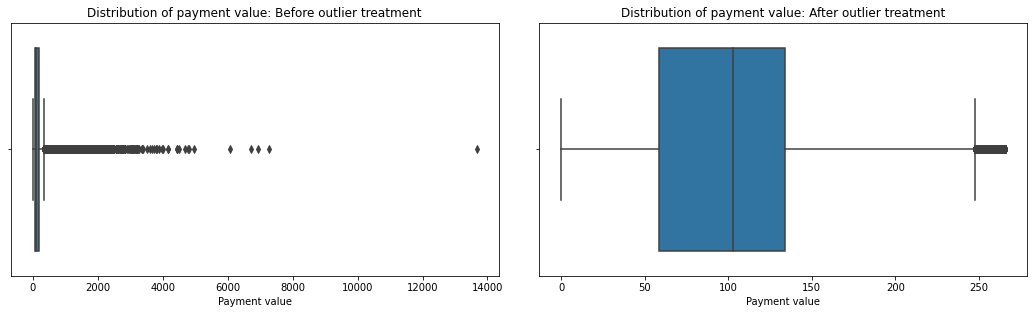

In [343]:
# visualize data
plt.figure(figsize=(15, 5))

## --BEFORE OUTLIER TREATMENT--
plt.subplot(1, 2, 1)
sns.boxplot(data=join_tbl, x="payment_value")
plt.xlabel("Payment value")
plt.title("Distribution of payment value: Before outlier treatment")

## --AFTER OUTLIER TREATMENT---
plt.subplot(1, 2, 2)
# get upper value of payment_value
upper_payment_value = join_tbl["payment_value"].quantile(q=0.75)*1.5

# get middle value of payment_value
mid_payment_value = join_tbl["payment_value"].median()

# replace outliers with median
join_tbl.loc[join_tbl["payment_value"] > upper_payment_value]=mid_payment_value

# recheck outliers in payment_value
sns.boxplot(data=join_tbl, x="payment_value")
plt.xlabel("Payment value")
plt.title("Distribution of payment value: After outlier treatment")

plt.tight_layout(pad=3)

# 4 Data exploration

In [344]:
# remove strange values
join_tbl = join_tbl[join_tbl.order_id != 102.78]
join_tbl.head()

,order_id,payment_type,payment_value,review_score,product_id,order_purchase_timestamp,product_category_name_english
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33,1.0,af74cc53dcffc8384b29e7abfa41902b,2018-04-25 22:01:49,home_construction
1,d86305c284cecff56c7ee9d3fbd4f8d6,credit_card,93.72,4.0,af74cc53dcffc8384b29e7abfa41902b,2018-04-15 22:53:59,home_construction
3,6a26bd1a037993f1205073dbeda67db4,credit_card,67.12,4.0,679a3e5e1d2bb68982be5734c6e55e63,2018-02-15 13:53:42,home_construction
4,1d84d00f6d2334d63f35ba528cd0d99d,boleto,63.74,5.0,679a3e5e1d2bb68982be5734c6e55e63,2018-02-10 16:50:42,home_construction
5,968a408760f771cab3ce5db012e90a1f,boleto,70.75,1.0,679a3e5e1d2bb68982be5734c6e55e63,2018-03-10 22:58:30,home_construction


## 4.1 Top selling products

### 4.1.1 Product sales

In [345]:
# prepare data
top_selling_products = join_tbl["product_category_name_english"].value_counts().to_frame()
top_selling_products = top_selling_products.reset_index().rename(columns={"index":"product_category", "product_category_name_english":"count"})
top = top_selling_products.head(10)
last = top_selling_products.tail(10)

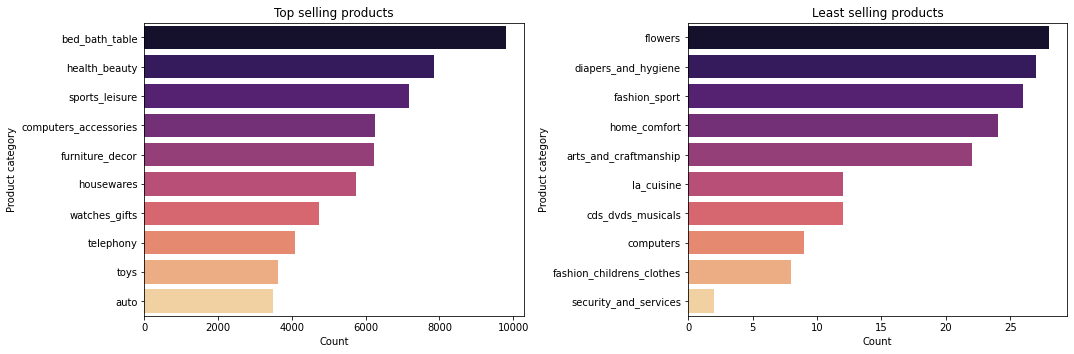

In [346]:
# visualize data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=top, x="count", y="product_category", palette="magma")
plt.title("Top selling products")
plt.xlabel("Count")
plt.ylabel("Product category")

plt.subplot(1, 2, 2)
sns.barplot(data=last, x="count", y="product_category", palette="magma")
plt.title("Least selling products")
plt.xlabel("Count")
plt.ylabel("Product category")

plt.tight_layout(pad=1)

### 4.1.2 Revenue based on product categories

In [347]:
# revenues based on product categories
revenue_product = join_tbl.groupby("product_category_name_english")
revenue_product = revenue_product["payment_value"].sum()
revenue_product = revenue_product.to_frame().reset_index().sort_values("payment_value", ascending=False)
revenue_product_top10 = revenue_product.head(10)
revenue_product_last10 = revenue_product.tail(10)

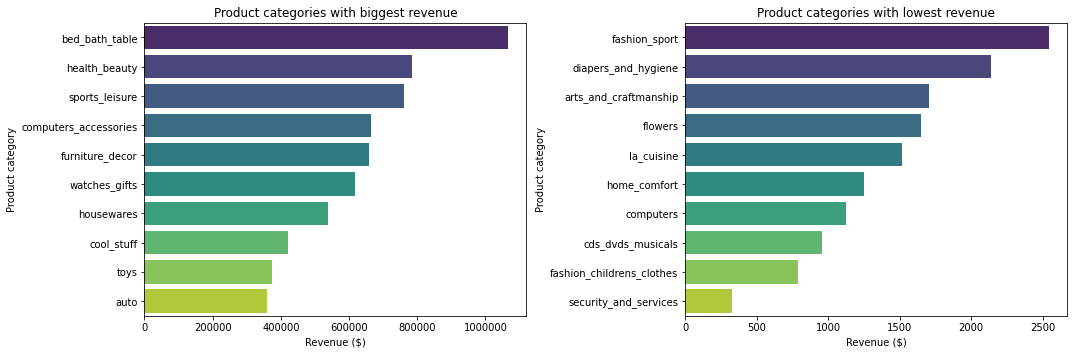

In [348]:
# biggest revenue

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.ticklabel_format(style='plain', axis='x')
revenue_product_top10 = sns.barplot(data=revenue_product_top10, 
                                    y="product_category_name_english", 
                                    x="payment_value", palette="viridis")
revenue_product_top10.set(xlabel="Revenue (\$)", 
                          ylabel="Product category", 
                          title="Product categories with biggest revenue")

plt.subplot(1, 2, 2)
# lowest revenue
revenue_product_last10 = sns.barplot(data=revenue_product_last10, 
                                     y="product_category_name_english", 
                                     x="payment_value", palette="viridis")
revenue_product_last10.set(xlabel="Revenue (\$)", 
                           ylabel="Product category", 
                           title="Product categories with lowest revenue")

plt.tight_layout(pad=1)

## 4.2 Most popular payment methods

In [349]:
# prepare the data
payment_type_col = join_tbl["payment_type"].value_counts(normalize=True)*100
payment_type_col = payment_type_col.to_frame("count")
payment_type_col = payment_type_col.reset_index()
payment_type_col = payment_type_col.rename(columns={"index":"payment_type"})
payment_type_col["count"] = payment_type_col["count"].round(3)
payment_type_col

,payment_type,count
0,credit_card,73.461
1,boleto,19.490
2,voucher,5.516
3,debit_card,1.534


Text(0.5, 1.0, 'Most preferred payment methods')

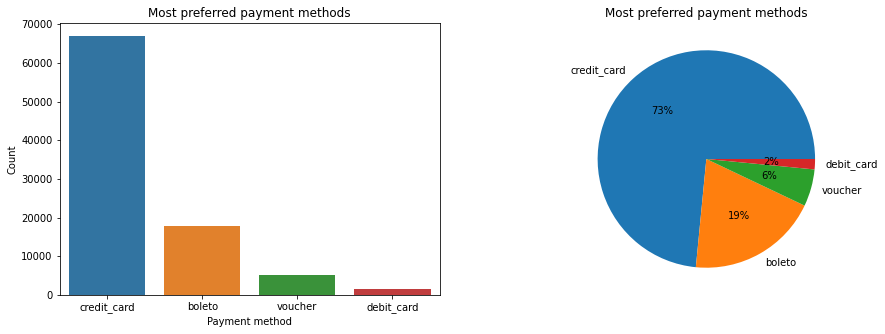

In [350]:
# visualize the data

plt.figure(figsize=(15, 5))

# bar plot
plt.subplot(1, 2, 1)
pop_payment_method = sns.countplot(data=join_tbl, x="payment_type")
pop_payment_method.set(xlabel="Payment method", ylabel="Count", title="Most preferred payment methods")

# pie chart
plt.subplot(1, 2, 2)
# explode = [0, 0, 0, 0.2]
plt.pie(data=payment_type_col, x="count",
        labels="payment_type", autopct='%.0f%%')
plt.title("Most preferred payment methods")

## 4.3 Top and least rated product categories

In [351]:
# Prepare the data
product_review = join_tbl.groupby("product_category_name_english").mean().sort_values("review_score", ascending=False).reset_index()
product_review = product_review.drop(columns = "payment_value")
top_rated = product_review.head(10)
last_rated = product_review.tail(10)

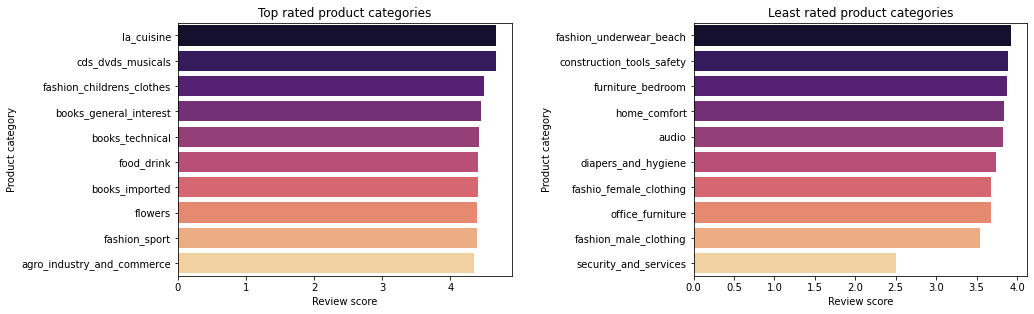

In [352]:
plt.figure(figsize=(15, 5))

# Top rated products
plt.subplot(1, 2, 1)
sns.barplot(data=top_rated, x="review_score", y="product_category_name_english", palette="magma")
plt.title("Top rated product categories")
plt.xlabel("Review score")
plt.ylabel("Product category")

# Least rated products
plt.subplot(1, 2, 2)
sns.barplot(data=last_rated, x="review_score", y="product_category_name_english", palette="magma")
plt.title("Least rated product categories")
plt.xlabel("Review score")
plt.ylabel("Product category")

plt.tight_layout(pad=3)